In [10]:
from typing import Dict, Any
import pickle
import pingouin as pg
import numpy as np
from multiprocessing import Pool
from itertools import combinations
import pandas as pd 
import re

In [11]:
#Run pairwise (2 subjects) correlation of the dynamic connectivity measures 
def blockwide_corr(sub_a_index, sub_b_index):
    #Load data
    with open("5_sub_Sintel_amygdala_cortical_subcortical_dyn_connectivity_width_30.pkl", "rb") as file:
        sub_data = pickle.load(file)
        file.close()
    
    #prepare dict
    dyn_conn_pairwise_corr: Dict[Any, Any] = {}
    for reg1_x_reg2 in list(sub_data[sub_a_index]['fMRI'].keys()):
        dyn_conn_pairwise_corr[reg1_x_reg2] = pg.corr(sub_data[sub_a_index]['fMRI'][reg1_x_reg2], sub_data[sub_b_index]['fMRI'][reg1_x_reg2],
                                                      method='pearson').r[0]
    return [sub_a_index, sub_b_index], dyn_conn_pairwise_corr 


In [12]:
# Function to output TR-wise differences in dynamic connectivity ###add region pair, ie Amygdala Right_x_dmPFC in the paper
def tr_diff(index_paire, region_pair): #
    #Load data
    with open("5_sub_Sintel_amygdala_cortical_subcortical_dyn_connectivity_width_30.pkl", "rb") as file:
        sub_data = pickle.load(file)
        file.close()
    #compute the difference between one region of interest (ie amygdala) and another brain region ()
    diff = np.subtract(sub_data[index_paire[0]]['fMRI'][region_pair], sub_data[index_paire[1]]['fMRI'][region_pair])
    return diff



In [13]:
### Initialize variables
#prepare a list of combination of all subject. Subject 1 as index 0, subject 2 index 1 and so on
sub_list = [0,1,2,3,4]
pairwise_subject_combination = list(combinations(sub_list, 2))

# Create dictionaries full of empty (nan) dataframes
pkl_file = open("5_sub_Sintel_amygdala_cortical_subcortical_dyn_connectivity_width_30.pkl", "rb")  # Use example subject to get network labels
prepped_labels = pickle.load(pkl_file)
connection_labels = list(prepped_labels[0]['fMRI'].keys())
pkl_file.close()

In [14]:
#pairwise_fMRI will be a list of all brain region combination and each of them will contain all_sub vs all_sub "matrix"
pairwise_fMRI = {key: pd.DataFrame(columns=sub_list, index=sub_list) for key in connection_labels}
#for TR analysis
TRs=558 #à gérer pour les différents films
r_ref_l = 'Left Amygdala'+'_x_'
r_ref_r = 'Right Amygdala'+'_x_'
r_interest_TR = [r_ref_l+'7Networks_LH_SalVentAttn_Med_1', r_ref_l+'7Networks_RH_SalVentAttn_Med_1',
                 r_ref_l+'7Networks_LH_Cont_PFCl_5', r_ref_l+'7Networks_RH_Cont_PFCl_9',
                 r_ref_l+'7Networks_LH_SomMot_4', r_ref_l+'7Networks_RH_SomMot_6',
                 r_ref_l+'Left Hippocampus', r_ref_l+'Right Hippocampus',
                 r_ref_r+'7Networks_LH_SalVentAttn_Med_1', r_ref_r+'7Networks_RH_SalVentAttn_Med_1',
                 r_ref_r+'7Networks_LH_Cont_PFCl_5', r_ref_r+'7Networks_RH_Cont_PFCl_9',
                 r_ref_r+'7Networks_LH_SomMot_4', r_ref_r+'7Networks_RH_SomMot_6',
                 r_ref_r+'Left Hippocampus', r_ref_r+'Right Hippocampus']
for r in r_interest_TR:
    for TR in range(1, TRs + 1):
        #for region in connection_labels: 
            pairwise_fMRI[r+f"_TR-{TR}"] = pd.DataFrame(columns=sub_list, index=sub_list)
            
pairwise_fMRI['Right Amygdala_x_7Networks_LH_SalVentAttn_Med_1_TR-1']

,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


#### Blockwide Correlations for every permutation of subjects x connections

In [15]:
# Blockwide Correlations for every permutation of subjects x connections
with Pool (processes=7) as pool: #processes = number of thread (coeur) I use on my computer
    dyn_conn_pairwise_corr_array = pool.starmap(blockwide_corr, pairwise_subject_combination)
pool.close()


In [16]:
#Assign the blockwise correlation computed earlier to a dict (of all brain region combination) containing corr value for all combination of subject 
#in a matrix. Only the upper part in different from nan values

for index_data_array in dyn_conn_pairwise_corr_array:
    pairwise_index = index_data_array[0]
    for connection in list(index_data_array[1].keys()):
        pairwise_fMRI[connection].loc[pairwise_index[0], pairwise_index[1]] = index_data_array[1][connection] 

In [17]:
pairwise_fMRI['Left Amygdala_x_7Networks_LH_Cont_Cing_1'] 

,0,1,2,3,4
0,NaN,0.079904,0.027447,-0.053273,0.031727
1,NaN,NaN,-0.044145,-0.014041,-0.119945
2,NaN,NaN,NaN,-0.041643,-0.113729
3,NaN,NaN,NaN,NaN,0.044393
4,NaN,NaN,NaN,NaN,NaN


Plot to see how it looks like for on combination of brain regions

<Axes: >

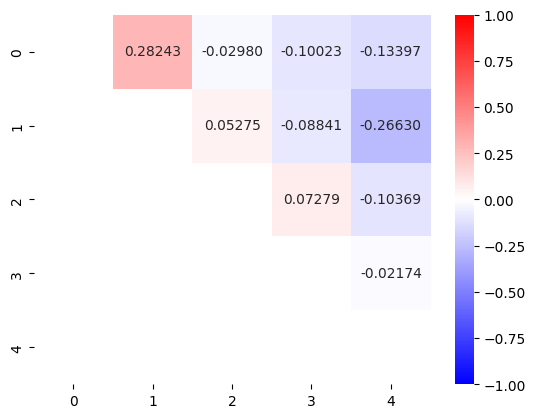

In [18]:
import seaborn as sns
from nilearn import plotting
test = pairwise_fMRI['Left Amygdala_x_7Networks_RH_Default_PFCdPFCm_2']
#test = pairwise_fMRI['Left Amygdala_x_7Networks_LH_Default_PFC_11']
test = test.astype(float) #need to convert object type into float to be able to plot it

#2 ways of plotting it, which on is the best? Colors are better with the second one, keep it?
#sns.heatmap(test, cmap='coolwarm', vmin= -1, vmax= 1, annot=True, fmt='.5f')
sns.heatmap(test,cmap=plotting.cm.bwr,vmin=-1, vmax=1, annot=True, fmt='.5f')

In [19]:
TRs=558
for sub_paire in pairwise_subject_combination:
    for region_paire in r_interest_TR:
        TR_diff = tr_diff(sub_paire, region_paire)
        for TRindex in range (0, TRs):
            pairwise_fMRI[region_paire+f"_TR-{TRindex+1}"].loc[sub_paire[0], sub_paire[1]]=TR_diff[TRindex]

pairwise_fMRI['Left Amygdala_x_7Networks_LH_Cont_PFCl_5_TR-139']

,0,1,2,3,4
0,NaN,1.197524,1.511036,0.449418,0.31417
1,NaN,NaN,0.313512,-0.748105,-0.883354
2,NaN,NaN,NaN,-1.061618,-1.196866
3,NaN,NaN,NaN,NaN,-0.135248
4,NaN,NaN,NaN,NaN,NaN


----------------------

## BEHAVIOR PART

In [20]:
behavior_data = pd.read_excel('data/Behavioural_PSY_scored.xlsx')
#behavior_data

In [21]:
#create a new excel file with the subjects ordered by increasing number. Subject S12 and S18 were excluded fron the study, then we have 30 subjects with numbers
#going from S01 to S32
col_names = behavior_data.columns[1:] #do not need Unamed 0 since it will not be the correct number when subjects will be ordered correctly
sub_ordered_behavior = pd.DataFrame(columns=col_names, index = np.arange(0,32,1))
#loop over subject number we want to find
for sub in range (1,33):
    #by default, we take the subject number alone ie 11, 23...
    s='' 
    #if the subject number is smaller than 10, we need to add a 0 before so that we only end up with one subject. 
    # We only want subject 01 for 1 and not subject 1,10,11,12...
    if sub < 10:
        s='0'
    ref = s+str(sub)
    #loop to fill in the new dataframe with the ordered subjects and their corresponding value
    for i in range (30):
        initial_sub = behavior_data['ID'][i]
        condition = re.search(ref,initial_sub)
        if condition!= None:
            new = behavior_data.iloc[i].values[1:]
            sub_ordered_behavior.iloc[(sub-1)]= new
sub_ordered_behavior.to_excel('ordered_by_sub_behavior_score.xlsx', index=True)          
#sub_ordered_behavior


In [22]:
#Run this part if we already have the excel of subjects ordered
sub_ordered_behavior = pd.read_excel('ordered_by_sub_behavior_score.xlsx')
#sub_ordered_behavior.dropna(how='all', inplace=True) #if I don't want nan values -> depend how handle missing subjects
sub_ordered_behavior

,Unnamed: 0,Timestamp_FollowUp,ID,"Think about everything that has happened to you over the past two weeks. Next, indicate approximately how often you felt the following emotions: [Joyfull / Happy]","Think about everything that has happened to you over the past two weeks. Next, indicate approximately how often you felt the following emotions: [Angry]","Think about everything that has happened to you over the past two weeks. Next, indicate approximately how often you felt the following emotions: [Sad / Demoralized]","Think about everything that has happened to you over the past two weeks. Next, indicate approximately how often you felt the following emotions: [Ashamed / Guilty]","Think about everything that has happened to you over the past two weeks. Next, indicate approximately how often you felt the following emotions: [Bored / Disinterested]",1. You have to work together with a colleague to finish an important project. He imposes his views on how to proceed and keeps criticizing your work. This event is... [Relevant to me],1. You have to work together with a colleague to finish an important project. He imposes his views on how to proceed and keeps criticizing your work. This event is... [Pleasant for me],...,bas_f,bas_r,bis,BIG5_ext,BIG5_agr,BIG5_con,BIG5_neu,BIG5_ope,erq_cr,erq_es
0,0,2021-08-02 15:53:37,S01,5.0,3.0,3.0,1.0,1.0,3.0,1.0,...,3.25,4.0,2.857143,31.0,40.0,34.0,27.0,40.0,33.0,13.0
1,1,2021-08-28 00:54:21,S02,4.0,3.0,2.0,1.0,1.0,2.0,1.0,...,2.75,3.0,2.142857,29.0,32.0,35.0,19.0,36.0,26.0,16.0
2,2,2021-08-18 18:23:55,S03,4.0,4.0,3.0,3.0,4.0,2.0,1.0,...,3.25,3.2,3.285714,22.0,29.0,32.0,26.0,47.0,36.0,12.0
3,3,2021-09-08 11:29:54,S04,5.0,2.0,1.0,2.0,1.0,3.0,1.0,...,3.00,3.8,3.285714,35.0,45.0,43.0,21.0,42.0,31.0,13.0
4,4,2021-09-08 10:41:53,S05,5.0,3.0,3.0,3.0,2.0,2.0,1.0,...,3.50,3.0,3.285714,21.0,36.0,30.0,22.0,42.0,26.0,18.0
5,5,2021-10-24 12:14:11,S06,4.0,3.0,4.0,2.0,5.0,3.0,1.0,...,3.25,3.0,3.285714,20.0,23.0,20.0,29.0,37.0,25.0,17.0
6,6,2021-10-03 16:45:24,S07,4.0,1.0,2.0,1.0,3.0,3.0,2.0,...,3.25,3.0,2.571429,19.0,39.0,25.0,21.0,41.0,31.0,21.0
7,7,2021-09-13 11:59:20,S08,4.0,3.0,2.0,1.0,1.0,4.0,1.0,...,3.00,3.6,3.285714,28.0,35.0,31.0,24.0,34.0,36.0,5.0
8,8,2021-10-03 16:08:28,S09,4.0,1.0,3.0,1.0,3.0,2.0,1.0,...,2.25,3.0,3.285714,22.0,33.0,28.0,25.0,28.0,28.0,18.0
9,9,2021-10-04 10:03:04,S10,4.0,2.0,3.0,2.0,2.0,3.0,3.0,...,3.00,3.2,2.571429,31.0,31.0,37.0,17.0,42.0,21.0,11.0


In [23]:
start_column_name = "cov_total"  # the name of the column you want to start from
#take all the behavior data from cov_total to the end
name_behavior_interet = ['ID']
name_behavior_interet2 = list(sub_ordered_behavior.columns[sub_ordered_behavior.columns.get_loc(start_column_name):])
name_behavior_interet.extend(name_behavior_interet2)
behavior_data_interest = sub_ordered_behavior[name_behavior_interet]
#behavior_data_interest

In [24]:
#Take only the first 5 subjects
five_sub_behavior = behavior_data_interest[:5]

In [25]:
#pairwise_behavior will be a list of all behavior of interest with the difference value for the n value

#we exclude the subject number for the analysis -> start at 1
labels = name_behavior_interet[1:]
#sub_list = [0,1,2,3,4] #from before
pairwise_behavior = {key: pd.DataFrame(columns=sub_list, index=sub_list) for key in labels}
for index_arrax in pairwise_subject_combination:
    Sub_A = five_sub_behavior.iloc[index_arrax[0]]
    Sub_B = five_sub_behavior.iloc[index_arrax[1]]
    for label in labels:
        pairwise_behavior[label].loc[index_arrax[0], index_arrax[1]] = (Sub_A[label]- Sub_B[label])
pairwise_behavior['DASS_anx']

,0,1,2,3,4
0,NaN,2.0,-5.0,0.0,0.0
1,NaN,NaN,-7.0,-2.0,-2.0
2,NaN,NaN,NaN,5.0,5.0
3,NaN,NaN,NaN,NaN,0.0
4,NaN,NaN,NaN,NaN,NaN


In [26]:
pairwise_data = {"fMRI": pairwise_fMRI, "behavior": pairwise_behavior}

# Save dictionary using pickle
pkl_file = open("Pairwise_Data.pkl", "wb")
pickle.dump(pairwise_data, pkl_file)
pkl_file.close()